In [27]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import concatenate
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras.layers import Masking
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

# {'DD': 0.001, 'DP2': 0.0004, 'DP1': 0.00035, 'HP1': 0.00005, 'HP2': 0.0001, 'HD': 0.0002}

In [28]:
df = pd.read_csv('data/daily_total.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE            datetime64[ns]
USERCOUNT                int64
SECONDSSPENT             int64
QUANTITY                 int64
VOLUME                 float64
WEIGHT                 float64
PRICE                  float64
dtype: object

In [29]:
df = df[df['DATE'] > '2022-08-10']
# fill missing dates with 0
df.index = df['DATE']
df = df.reindex(pd.date_range(min(df['DATE']), max(df['DATE'])), fill_value=0).drop('DATE', axis=1)
df['SECONDSSPENTNextDay'] = df['SECONDSSPENT'].shift(-1)
df

,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE,SECONDSSPENTNextDay
2022-08-16,15,24864,1564,5.510447,606.628000,7714.46,648639.0
2022-08-17,46,648639,153271,900.823306,87245.837728,731227.04,1535976.0
2022-08-18,72,1535976,353781,2687.981897,247269.820740,2135600.74,1253113.0
2022-08-19,70,1253113,395921,2944.799061,262781.058485,2136707.30,67002.0
2022-08-20,6,67002,593,14.290446,975.280591,14861.86,0.0
...,...,...,...,...,...,...,...
2023-09-25,101,1171721,854092,2678.434373,292547.191456,1875797.61,1249771.0
2023-09-26,110,1249771,1016887,3483.392239,371822.547589,2318629.60,1257222.0
2023-09-27,104,1257222,939123,2998.222002,300263.198492,1850064.42,1339688.0
2023-09-28,109,1339688,1224169,3863.465093,384720.606181,2390796.27,1381580.0


In [30]:
seconds_spent_next_day = df['SECONDSSPENTNextDay'].values.reshape(-1, 1)
seconds_spent = df['SECONDSSPENT'].values.reshape(-1, 1)
user_count = df['USERCOUNT'].values.reshape(-1, 1)
quantity = df['QUANTITY'].values.reshape(-1, 1)
volume = df['VOLUME'].values.reshape(-1, 1)
weight = df['WEIGHT'].values.reshape(-1, 1)
price = df['PRICE'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))

dataset = scaler.fit_transform(hstack((quantity, volume, weight, price, seconds_spent_next_day)))

In [31]:
# def df_to_X_y(dataset, window_size=1):
#     # dataset = df.values
#     X = []
#     y = []
#     for i in range(len(dataset) - window_size):
#         row = [[j] for j in dataset[i: i + window_size, :]]
#         # row = dataset[i: i + window_size]
#         X.append(row)
#         y.append(dataset[i + window_size][-1])
#     return np.array(X), np.array(y)

# split = int(len(dataset) * 0.9)
# window_size = 1

# X, y = df_to_X_y(dataset, window_size)
# print(X.shape, y.shape)
# train_X, train_y = X[:split], y[:split]
# test_X, test_y = X[split:], y[split:]

# train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], train_X.shape[3]))
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], test_X.shape[3]))

# # train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [32]:
# split into train and test sets
window_size = 1
split = int(len(dataset) * 0.9)

train, test = dataset[:-1][:split], dataset[:-1][split:]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(369, 1, 4) (369,) (40, 1, 4) (40,)


Epoch 1/70


2023-12-14 19:26:09.211368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [369]
	 [[{{node Placeholder/_11}}]]
2023-12-14 19:26:09.211638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [369]
	 [[{{node Placeholder/_11}}]]
2023-12-14 19:26:14.061438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [40]


12/12 - 6s - loss: 0.3449 - val_loss: 0.2304 - 6s/epoch - 533ms/step
Epoch 2/70
12/12 - 0s - loss: 0.3429 - val_loss: 0.2285 - 52ms/epoch - 4ms/step
Epoch 3/70
12/12 - 0s - loss: 0.3410 - val_loss: 0.2269 - 51ms/epoch - 4ms/step
Epoch 4/70
12/12 - 0s - loss: 0.3394 - val_loss: 0.2256 - 52ms/epoch - 4ms/step
Epoch 5/70
12/12 - 0s - loss: 0.3381 - val_loss: 0.2243 - 51ms/epoch - 4ms/step
Epoch 6/70
12/12 - 0s - loss: 0.3369 - val_loss: 0.2231 - 51ms/epoch - 4ms/step
Epoch 7/70
12/12 - 0s - loss: 0.3359 - val_loss: 0.2219 - 50ms/epoch - 4ms/step
Epoch 8/70
12/12 - 0s - loss: 0.3349 - val_loss: 0.2208 - 50ms/epoch - 4ms/step
Epoch 9/70
12/12 - 0s - loss: 0.3339 - val_loss: 0.2198 - 47ms/epoch - 4ms/step
Epoch 10/70
12/12 - 0s - loss: 0.3330 - val_loss: 0.2187 - 47ms/epoch - 4ms/step
Epoch 11/70
12/12 - 0s - loss: 0.3321 - val_loss: 0.2176 - 45ms/epoch - 4ms/step
Epoch 12/70
12/12 - 0s - loss: 0.3312 - val_loss: 0.2166 - 47ms/epoch - 4ms/step
Epoch 13/70
12/12 - 0s - loss: 0.3302 - val_loss

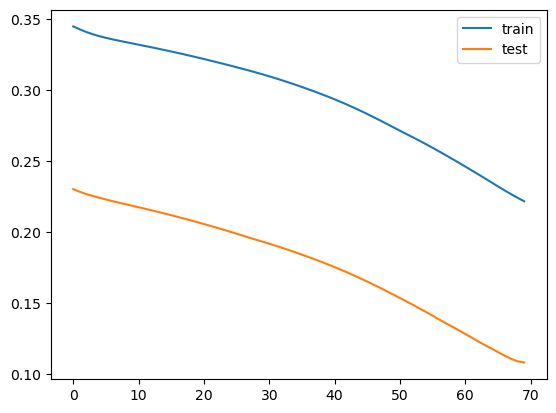

In [33]:
# design network
np.random.seed(1234)
tf.random.set_seed(1234)

tf.keras.utils.set_random_seed(1234)
tf.config.experimental.enable_op_determinism()

optim = optimizers.Adam(lr=0.0001)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=optim)

# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
# make a prediction
yhat = model.predict(test_X)
X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(X.shape, yhat.shape)

# invert scaling for forecast
inv_yhat = concatenate((X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]

# invert scaling for actual
y = test_y.reshape((len(test_y), 1))
dataset_y = concatenate((X, y), axis=1)
dataset_y = scaler.inverse_transform(dataset_y)
inv_y = dataset_y[:, -1]
# inv_y = scaler.inverse_transform(test_y)
# inv_y = inv_y[:, -1]

2023-12-14 19:26:18.912482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [40,1,4]
	 [[{{node Placeholder/_10}}]]
2023-12-14 19:26:18.912706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [40,1,4]
	 [[{{node Placeholder/_10}}]]


2/2 [==============================] - 1s 2ms/step
(40, 4) (40, 1)


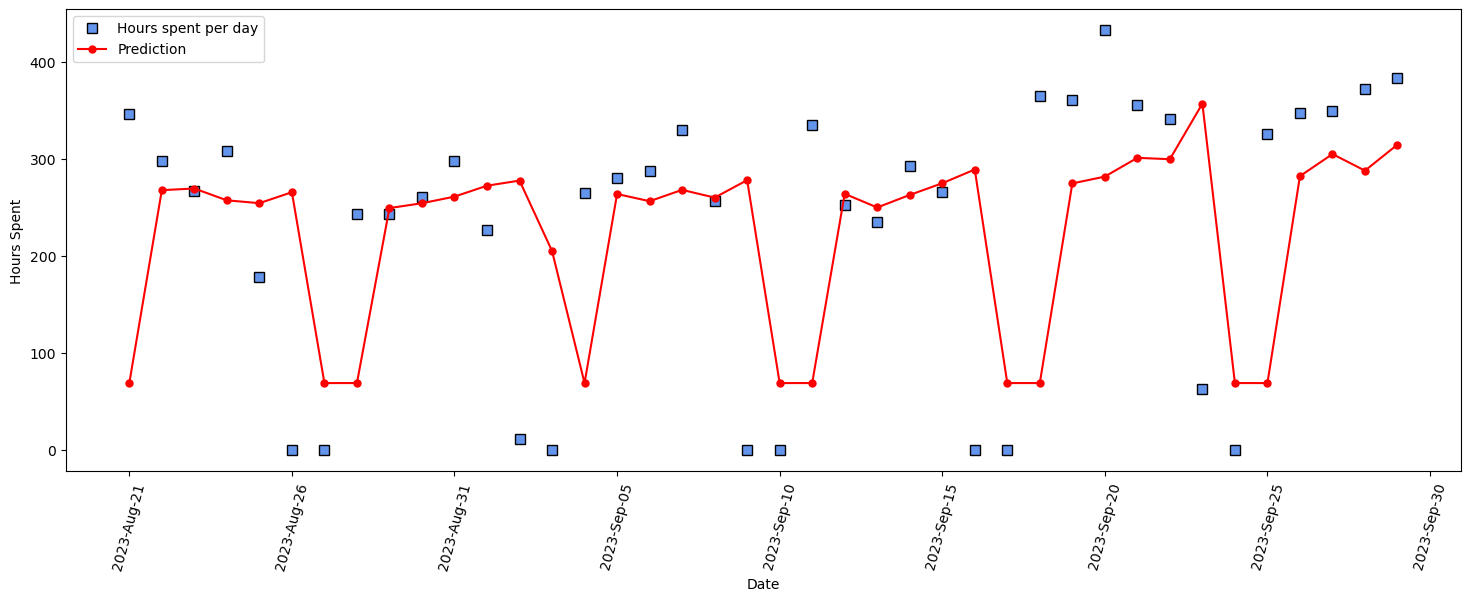

In [35]:
df['DATE'] = df.index
date = df['DATE'][split + window_size:]

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(date, inv_y / 3600, 
        linestyle='none', 
        marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Hours spent per day')
ax.plot(date, inv_yhat / 3600, 
        linestyle='-',
        marker='o',
        markersize=5,
        color='red',
        label='Prediction')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Hours Spent')
plt.xticks(rotation=75)
ax.legend(loc='upper left')
plt.show()


In [36]:
# MAE
mae = mean_absolute_error(inv_y[:-1], inv_yhat[1:]) / 3600
print('MAE: %.3f' % (mae))

MAE: 50.172


In [37]:
last = dataset[-1, :-1].reshape((1, test_X.shape[1], test_X.shape[2]))

# make a prediction
forecast = model.predict(last)
X = last.reshape((last.shape[0], last.shape[2]))
print(X.shape, forecast.shape)

# invert scaling for forecast
inv_forecast = concatenate((X, forecast), axis=1)
inv_forecast = scaler.inverse_transform(inv_forecast)
inv_forecast = inv_forecast[:, -1]

1/1 [==============================] - 0s 25ms/step
(1, 4) (1, 1)


2023-12-14 19:26:20.553775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,1,4]
	 [[{{node Placeholder/_10}}]]
2023-12-14 19:26:20.554036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,1,4]
	 [[{{node Placeholder/_10}}]]


In [38]:
print('Actual: %.3f' % (df['SECONDSSPENT'][-1] / 3600))
print('Forecast: %.3f' % (inv_forecast / 3600))

Actual: 383.772
Forecast: 308.055
